In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import (roc_curve, auc, accuracy_score, precision_score, 
                             recall_score, f1_score, log_loss, brier_score_loss)
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

# Load dataset
df = pd.read_excel(r"stratifiedcohort.xlsx")

# Define features and target
features = [ 'bmi', 'hc', 'wc', 'bf', 'ffm']
target = 'ascvd'
X, y = df[features], df[target]

# Nested CV setup
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
param_grid = {
    'svm__C': [ 0.1, 1, 10, 100],      
    'svm__gamma': [0.01, 0.1]  
}

# Storage for metrics
bootstrap_metrics = {metric: [] for metric in [
    'accuracy', 'precision_micro', 'precision_macro',
    'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro',
    'roc_auc_micro', 'roc_auc_macro'
]}
class_metrics_bootstrap = {}
aucs, tprs = {}, {}
tprs_micro, aucs_micro, tprs_macro, aucs_macro = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)
log_loss_scores, brier_scores = [], []
y_probs_all, y_true_all = [], []

# Bootstrap confidence interval function
def bootstrap_ci(data, num_samples=1000, confidence=0.95):
    np.random.seed(1)
    if not data:
        return np.nan, (np.nan, np.nan)
    
    samples = np.random.choice(data, size=(num_samples, len(data)), replace=True)
    means = np.mean(samples, axis=1)
    return np.mean(means), (np.percentile(means, (1 - confidence) / 2 * 100), 
                            np.percentile(means, (1 + confidence) / 2 * 100))

# Handle class imbalance
class_counts = Counter(y)
majority_class = max(class_counts, key=class_counts.get)
sampling_strategy = {cls: int(0.4 * class_counts[majority_class]) 
                     for cls in class_counts if class_counts[cls] < class_counts[majority_class]}

# Nested CV loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"Processing Fold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    classes_in_fold = np.unique(y_train)

    # Pipeline: StandardScaler + SMOTE + Kernelized SVM
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, kind='borderline-1', random_state=0)),
        ('svm', SVC(probability=True, random_state=0))
    ])

    # Hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters selected in this fold
    print(f"Best Hyperparameters : {grid_search.best_params_}\n")
        
    y_pred = best_model.predict(X_test)
    y_probs = best_model.predict_proba(X_test)

    y_true_all.extend(y_test)
    y_probs_all.extend(y_probs)

    # Compute performance metrics
    bootstrap_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    for avg in ['micro', 'macro']:
        bootstrap_metrics[f'precision_{avg}'].append(precision_score(y_test, y_pred, average=avg, zero_division=0))
        bootstrap_metrics[f'recall_{avg}'].append(recall_score(y_test, y_pred, average=avg, zero_division=0))
        bootstrap_metrics[f'f1_{avg}'].append(f1_score(y_test, y_pred, average=avg, zero_division=0))

    # Log Loss & Brier Score
    log_loss_scores.append(log_loss(y_test, y_probs))
    y_test_bin = label_binarize(y_test, classes=classes_in_fold)
    brier_scores.append(np.mean(np.sum((y_test_bin - y_probs) ** 2, axis=1)))
  
  # Compute ROC curve
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(classes_in_fold)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Store interpolated TPR values
        if i not in tprs:
            tprs[i] = []
            aucs[i] = []
        tprs[i].append(np.interp(mean_fpr, fpr[i], tpr[i]))
        aucs[i].append(roc_auc[i])

    # Compute ROC AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_probs.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    bootstrap_metrics['roc_auc_micro'].append(roc_auc_micro)

    mean_tpr_macro = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(len(classes_in_fold))], axis=0)
    roc_auc_macro = np.mean(list(roc_auc.values()))
    bootstrap_metrics['roc_auc_macro'].append(roc_auc_macro)

    tprs_micro.append(np.interp(mean_fpr, fpr_micro, tpr_micro))
    aucs_micro.append(roc_auc_micro)
    tprs_macro.append(mean_tpr_macro)
    aucs_macro.append(roc_auc_macro)

    # Store per-class metrics
    for i, class_label in enumerate(classes_in_fold):
        if class_label not in class_metrics_bootstrap:
            class_metrics_bootstrap[class_label] = {'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

        class_metrics_bootstrap[class_label]['precision'].append(
            precision_score(y_test, y_pred, labels=[class_label], average='weighted', zero_division=0))
        class_metrics_bootstrap[class_label]['recall'].append(
            recall_score(y_test, y_pred, labels=[class_label], average='weighted', zero_division=0))
        class_metrics_bootstrap[class_label]['f1'].append(
            f1_score(y_test, y_pred, labels=[class_label], average='weighted', zero_division=0))
        class_metrics_bootstrap[class_label]['roc_auc'].append(roc_auc[i])
    



Processing Fold 1
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.1}

Processing Fold 2
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 3
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 4
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 6
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Hyperparameters : {'svm__C': 100, 'svm__gamma': 0.01}

Processing Fold 8
Fitting 10


===== Multiclass Metrics (Bootstrap Mean & 95% CI) =====
              accuracy  precision_micro  precision_macro  recall_micro  \
Mean          0.659498         0.659498         0.500576      0.659498   
95% CI Lower  0.651177         0.651177         0.484832      0.651177   
95% CI Upper  0.667436         0.667436         0.516887      0.667436   

              recall_macro  f1_micro  f1_macro  roc_auc_micro  roc_auc_macro  
Mean              0.513825  0.659498  0.490786       0.882804       0.819599  
95% CI Lower      0.497841  0.651177  0.476559       0.879045       0.813406  
95% CI Upper      0.530016  0.667436  0.505686       0.886658       0.825627  

===== Per-Class Metrics (Bootstrap Mean & 95% CI) =====
              Class 1 Precision  Class 1 Recall  Class 1 F1  Class 1 Roc_auc  \
Mean                   0.831173        0.856601    0.842292         0.882745   
95% CI Lower           0.823334        0.846076    0.836325         0.876550   
95% CI Upper           0.838342 

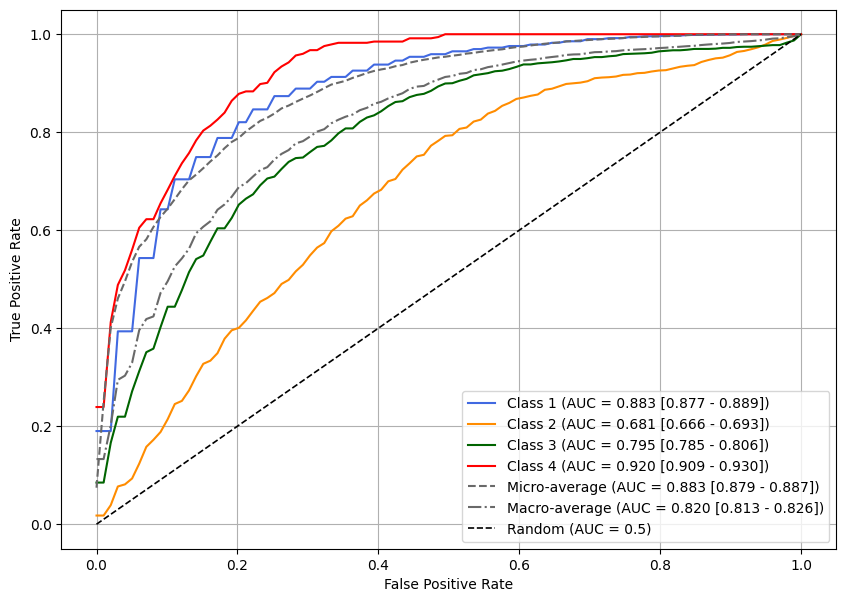

In [3]:
# Multiclass metrics
final_results = {}
for metric, values in bootstrap_metrics.items():
    mean, ci = bootstrap_ci(values)
    final_results[metric] = [mean, ci[0], ci[1]]

df_results = pd.DataFrame(final_results, index=['Mean', '95% CI Lower', '95% CI Upper'])
df_results.to_excel("multiclass_metrics_bootstrap.xlsx")
print("\n===== Multiclass Metrics (Bootstrap Mean & 95% CI) =====")
print(df_results)

# Per-class metrics
per_class_results = {}
for class_label, metrics in class_metrics_bootstrap.items():
    for metric_name, values in metrics.items():
        mean, ci = bootstrap_ci(values)
        per_class_results[f'Class {class_label} {metric_name.capitalize()}'] = [mean, ci[0], ci[1]]

df_per_class = pd.DataFrame(per_class_results, index=['Mean', '95% CI Lower', '95% CI Upper'])
df_per_class.to_excel("per_class_metrics_bootstrap.xlsx")
print("\n===== Per-Class Metrics (Bootstrap Mean & 95% CI) =====")
print(df_per_class)


# Log Loss and Brier Score
mean_log_loss, ci_log_loss = bootstrap_ci(log_loss_scores)
mean_brier, ci_brier = bootstrap_ci(brier_scores)
print(f"Multiclass Log Loss: {mean_log_loss:.4f} (95% CI: {ci_log_loss[0]:.4f} - {ci_log_loss[1]:.4f})")
print(f"Multiclass Brier Score: {mean_brier:.4f} (95% CI: {ci_brier[0]:.4f} - {ci_brier[1]:.4f})")

df_log_brier = pd.DataFrame({
    'Metric': ['Log Loss', 'Brier Score'],
    'Mean': [mean_log_loss, mean_brier],
    '95% CI Lower': [ci_log_loss[0], ci_brier[0]],
    '95% CI Upper': [ci_log_loss[1], ci_brier[1]]
})
df_log_brier.to_excel("log_brier_bootstrap.xlsx", index=False)


# Plot ROC Curves
plt.figure(figsize=(10, 7))
class_labels = np.unique(y) 
colors = ['royalblue', 'darkorange', 'darkgreen', 'red', 'purple', 'brown', 'cyan']
for i, color in zip(tprs.keys(), colors):
    mean_auc, ci = bootstrap_ci(aucs[i])
    plt.plot(
        mean_fpr, np.mean(tprs[i], axis=0), color=color, linewidth=1.5,
        label=f"Class {class_labels[i]} (AUC = {mean_auc:.3f} [{ci[0]:.3f} - {ci[1]:.3f}])"
    )


mean_auc_micro, ci_micro = bootstrap_ci(aucs_micro)
plt.plot(
    mean_fpr, np.mean(tprs_micro, axis=0), linestyle="--", color="dimgray", linewidth=1.5,
    label=f"Micro-average (AUC = {mean_auc_micro:.3f} [{ci_micro[0]:.3f} - {ci_micro[1]:.3f}])"
)

mean_auc_macro, ci_macro = bootstrap_ci(aucs_macro)
plt.plot(
    mean_fpr, np.mean(tprs_macro, axis=0), linestyle="-.", color="dimgray", linewidth=1.5,
    label=f"Macro-average (AUC = {mean_auc_macro:.3f} [{ci_macro[0]:.3f} - {ci_macro[1]:.3f}])"
)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.2, label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()




In [5]:
import shap

# Initialize and train the final model
final_model = ImbPipeline([
    ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, kind='borderline-1', random_state=0)),
    ('scaler', StandardScaler()),
    ('svm', SVC( probability=True, random_state=0, C=100, gamma = 0.01))  # Using best C from param_grid
])
final_model.fit(X, y)

# Setup SHAP explainer 
explainer = shap.Explainer(final_model.predict_proba, X)
shap_values = explainer(X)  
feature_names = X.columns



ExactExplainer explainer: 445it [05:11,  1.42it/s]                         


C:\Users\mr zareh\AppData\Local\Temp\ipykernel_10584\285913716.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X, feature_names=feature_names)


SHAP Summary for Class 1


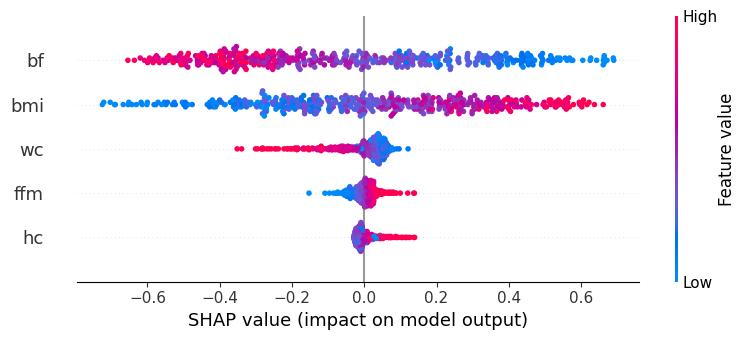

SHAP Summary for Class 2


C:\Users\mr zareh\AppData\Local\Temp\ipykernel_10584\285913716.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X, feature_names=feature_names)


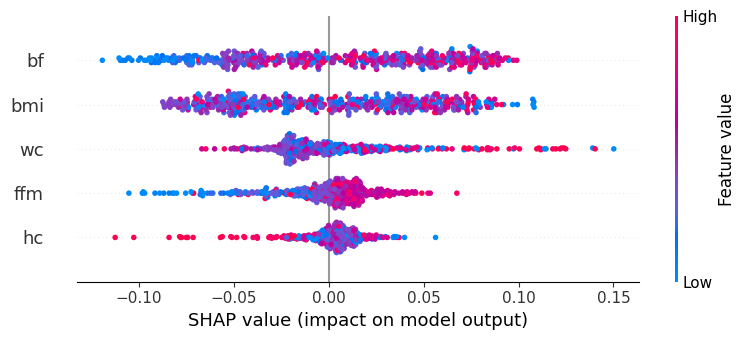

SHAP Summary for Class 3


C:\Users\mr zareh\AppData\Local\Temp\ipykernel_10584\285913716.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X, feature_names=feature_names)


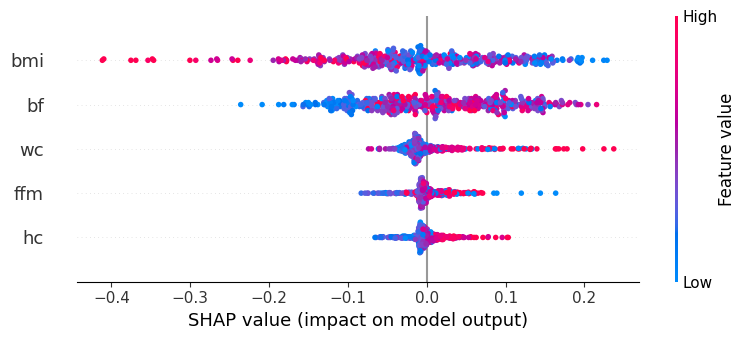

SHAP Summary for Class 4


C:\Users\mr zareh\AppData\Local\Temp\ipykernel_10584\285913716.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, i], X, feature_names=feature_names)


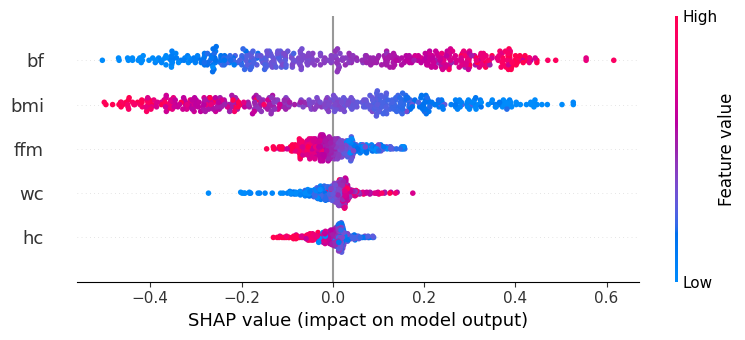

C:\Users\mr zareh\AppData\Local\Temp\ipykernel_10584\285913716.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names, class_names=class_names)


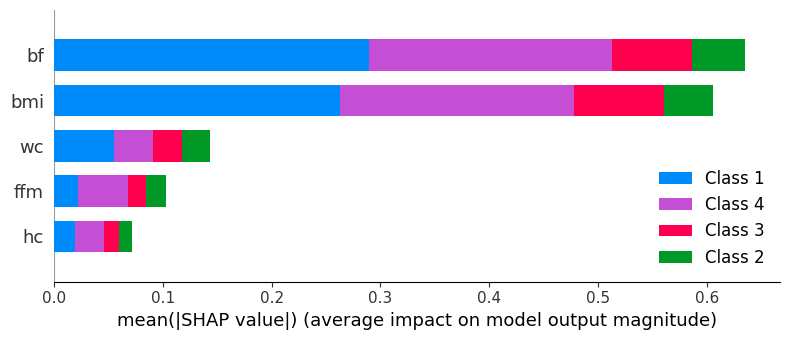

Force Plot for Instance 42, Class 1


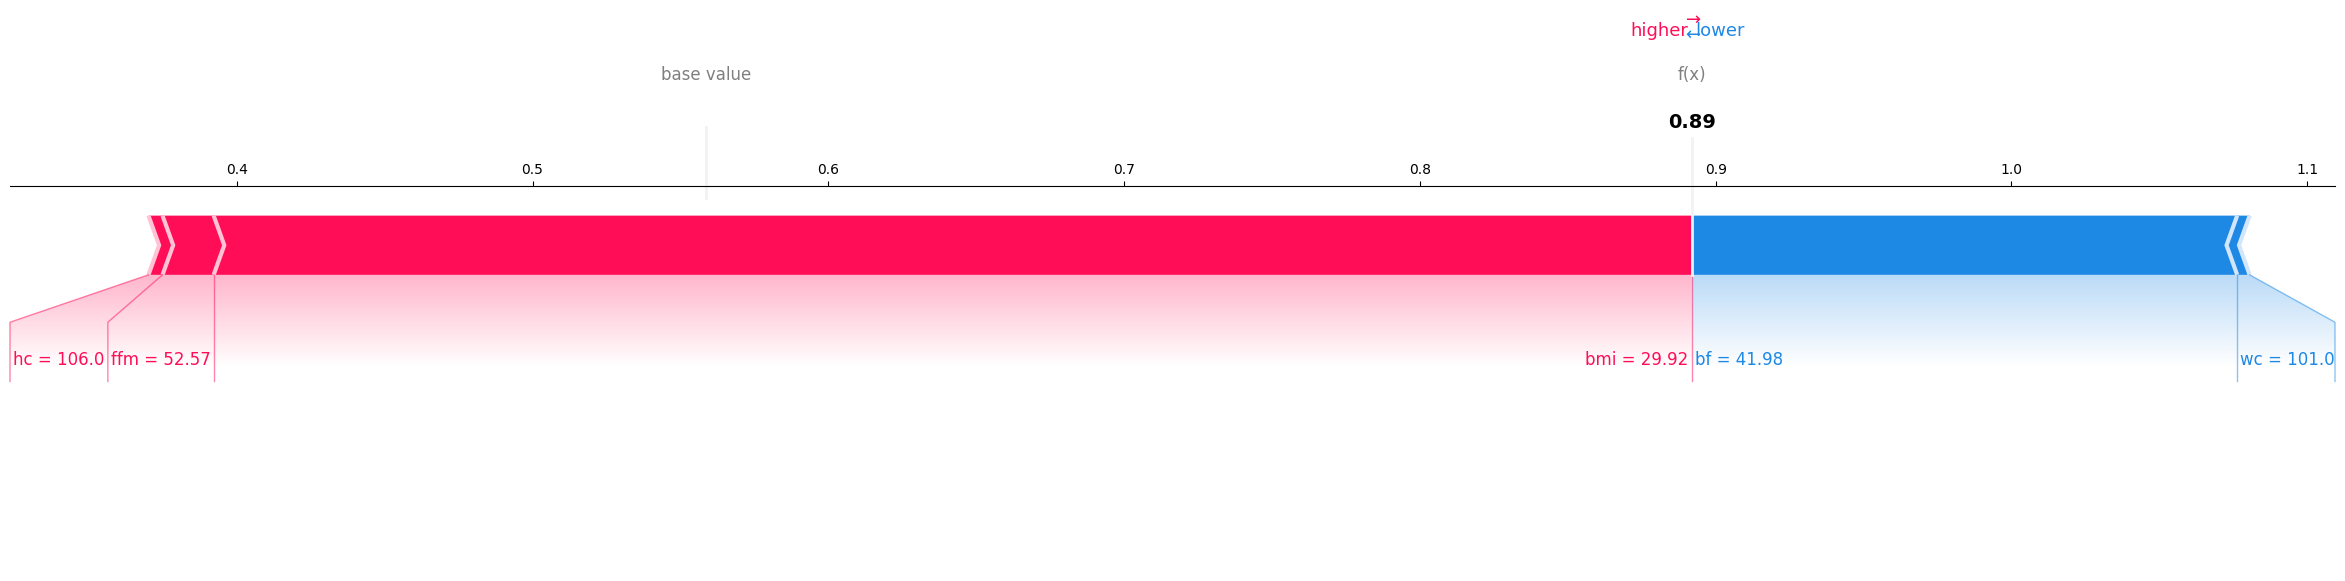

Force Plot for Instance 42, Class 2


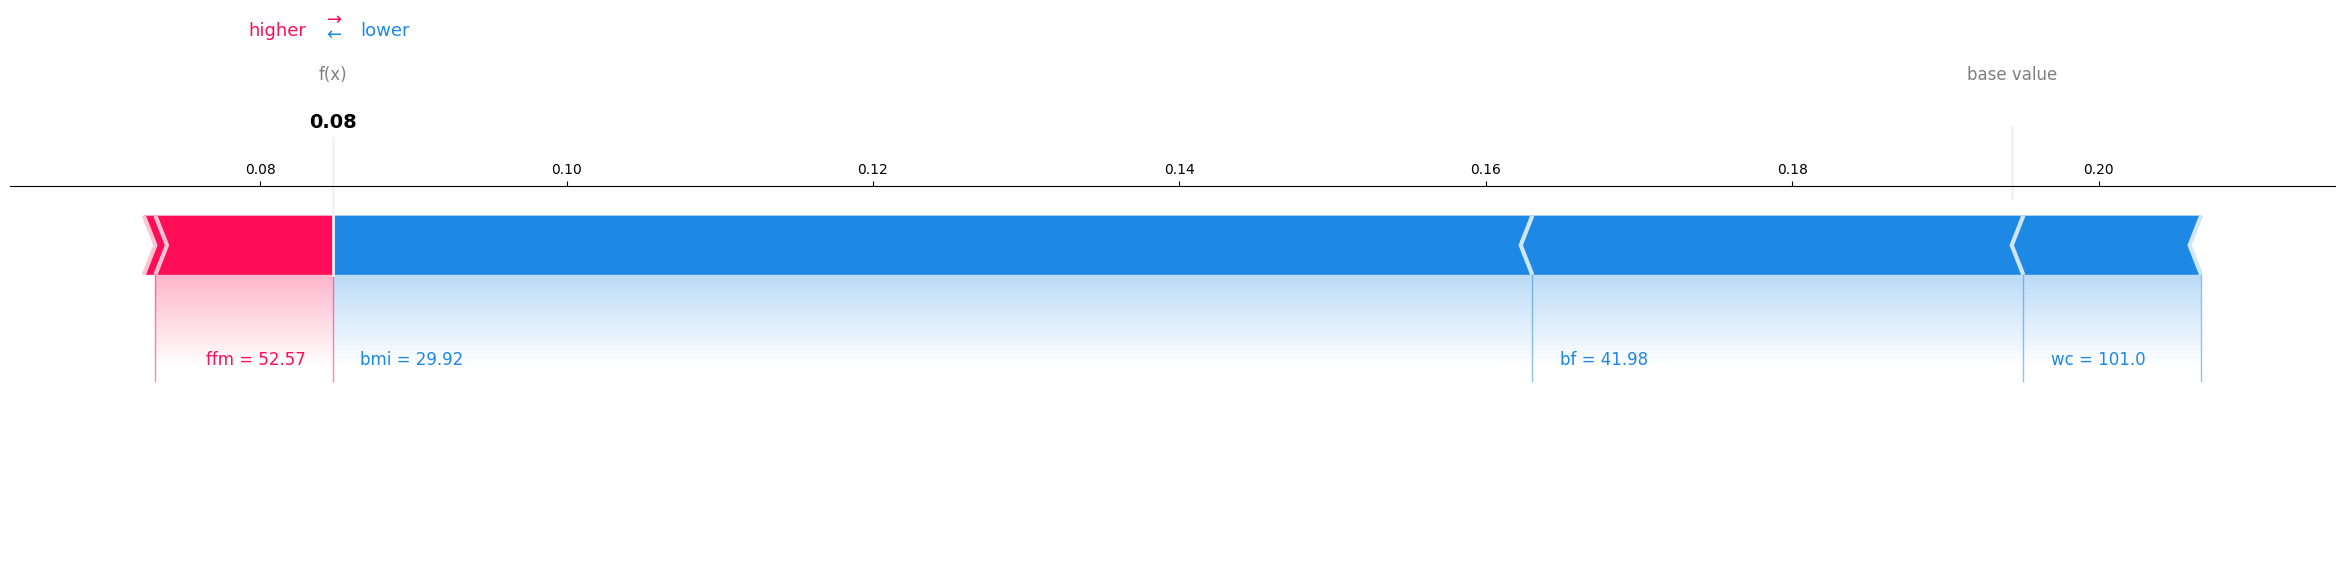

Force Plot for Instance 42, Class 3


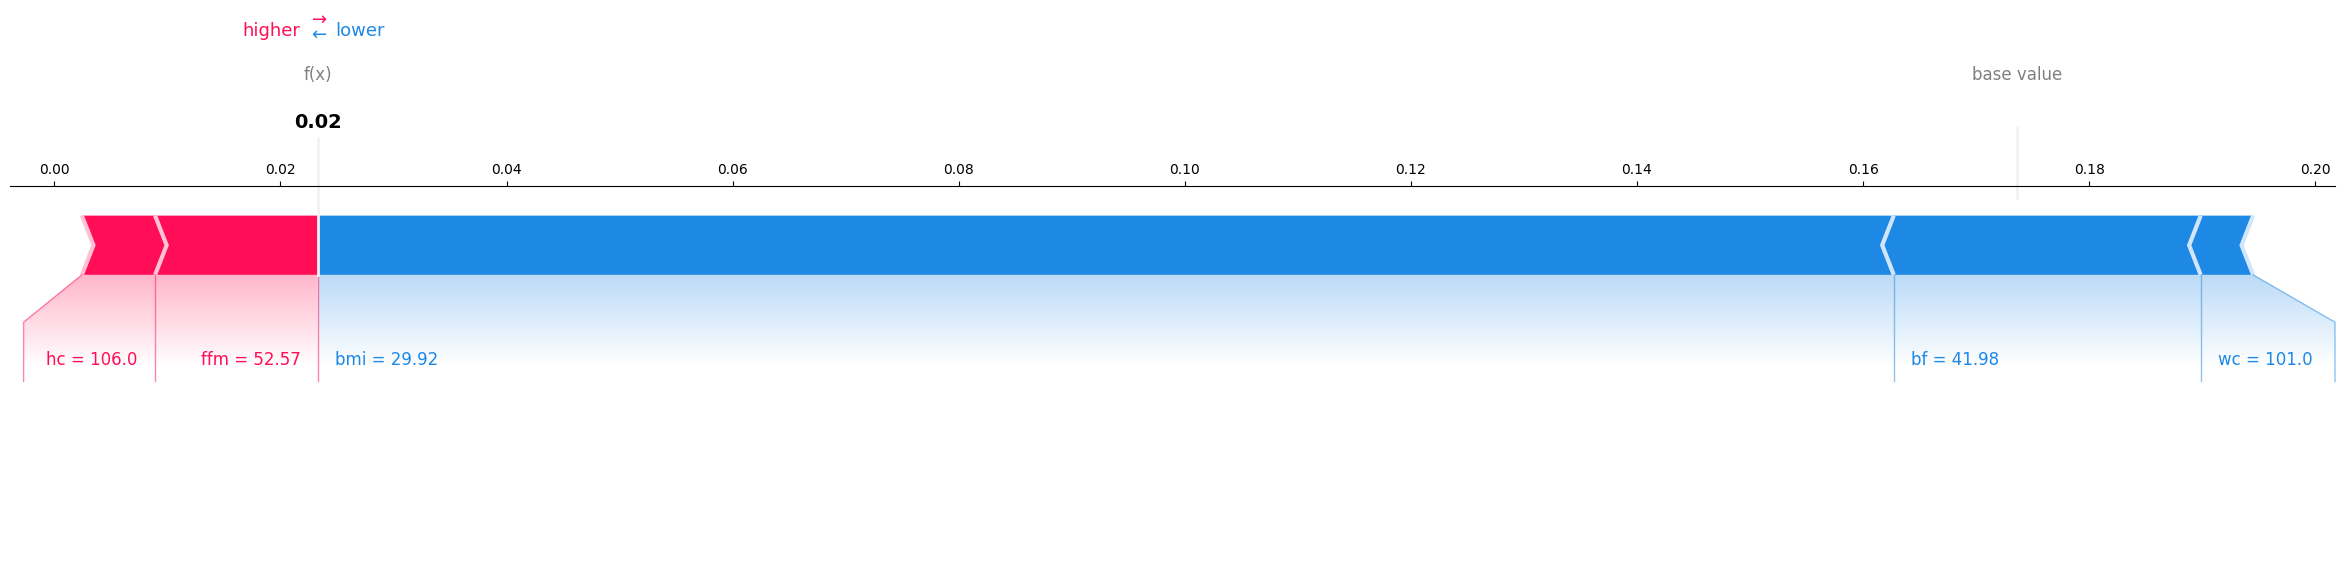

Force Plot for Instance 42, Class 4


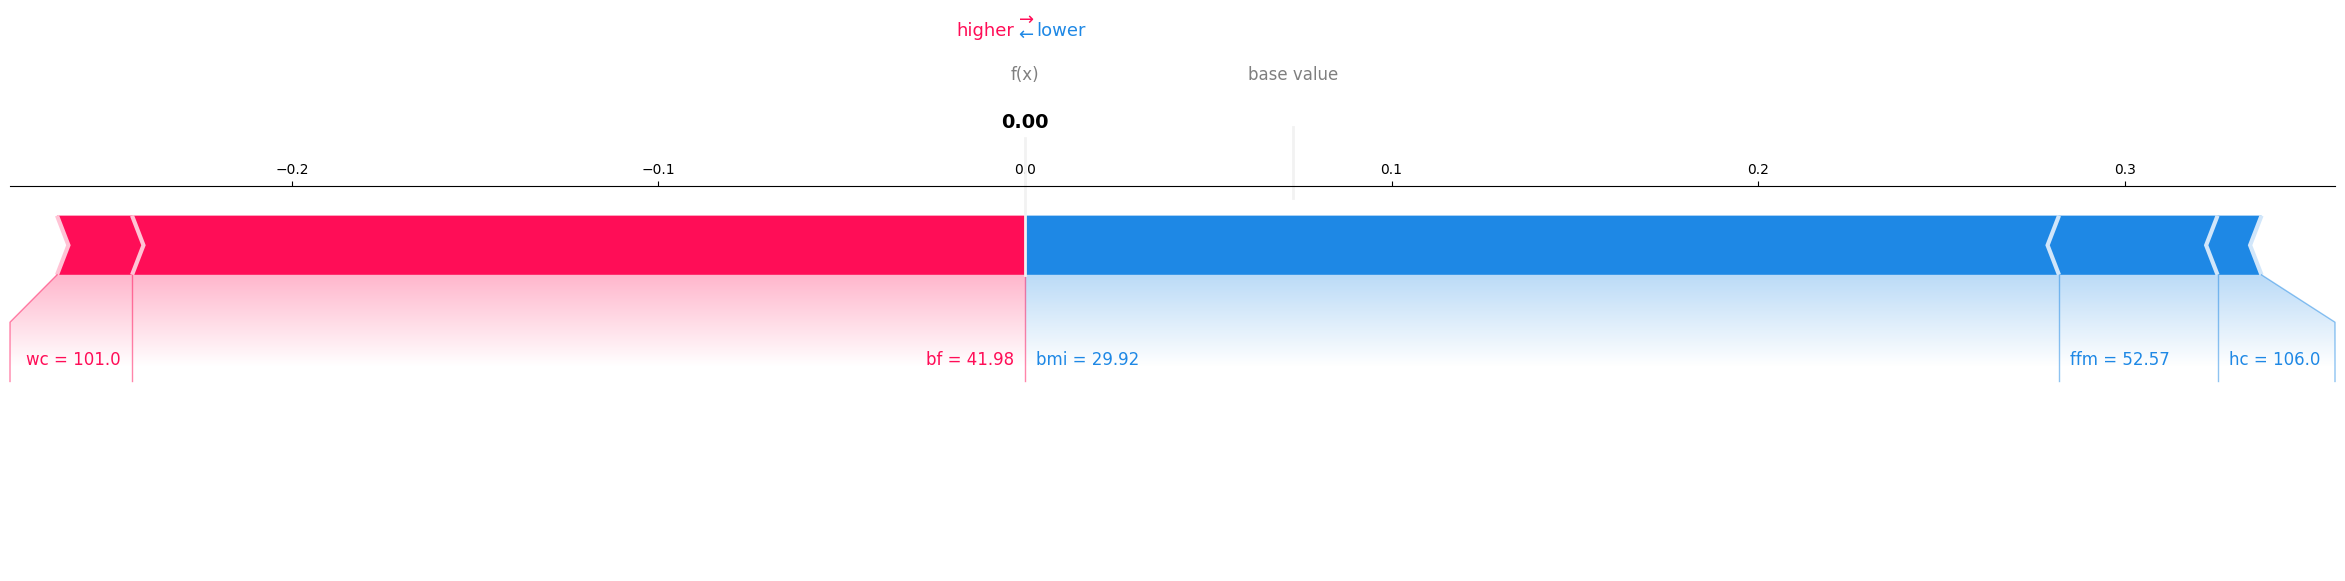

In [6]:

# SHAP summary plots for each class
num_classes = len(np.unique(y))  
for i in range(num_classes):
    print(f"SHAP Summary for Class {i+1}")
    plt.figure(figsize=(8, 5))
    shap.summary_plot(shap_values.values[:, :, i], X, feature_names=feature_names)
    plt.savefig(f"shap_summary_class_{i+1}.png", bbox_inches='tight', dpi=300)
    plt.close() 
    
# Aggregate SHAP summary plot showing feature importance across all classes
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"] 
plt.figure(figsize=(8, 5))  # Create a new figure and axis
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names, class_names=class_names)
plt.savefig("shap_feature_importance.png", bbox_inches='tight', dpi=300)
plt.close() 

# Force plot
shap.initjs() 

num_classes = shap_values.values.shape[2]

for class_index in range(num_classes):
    print(f"Force Plot for Instance 42, Class {class_index + 1}")
    force_plot = shap.plots.force(
        shap_values.base_values[42, class_index],  
        shap_values.values[42, :, class_index],  
        X.iloc[42].round(2),
        matplotlib=True, 
        figsize=(30, 5)
    )
    plt.show()  

